In [83]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory


In [84]:
import numpy as np
import matplotlib.pyplot as plt

def ddpm_forward(img, iterations, beta_start, beta_end, noise_scheduler="linear"):
    """
    DDPM forwarding process: Adding noise to the input image iteratively.
    
    Args:
        img (numpy.ndarray): Input image in RGB format.
        iterations (int): Number of iterations for adding noise.
        beta_start (float): Initial noise scale factor.
        beta_end (float): Final noise scale factor.
        
    Returns:
        list: List of images with added noise at every 100 iterations.
    """
    images = []
    
    # Calculate the uncoupling coefficients
    if noise_scheduler=="linear":
        betas = np.linspace(beta_start**2, beta_end**3, iterations)
    elif noise_scheduler=="cosine"
        s = beta_start**2
        betas = []
        for i in range(iterations):
            t = i / iterations
            beta = s * 0.5 * (np.cos(t * np.pi) + 1)
            betas.append(beta)
        
    for i in range(iterations):
        alpha = 1 - betas[i]
        alpha_bar = np.prod(1 - betas[:i])
        noise = np.random.normal(0, 1, img.shape)
        img = np.sqrt(alpha) * img + np.sqrt(1 - alpha_bar) * noise
        img = np.clip(img, 0, 1)
        
        if (i + 1) % 10 == 0:
            # print(img.shape)
            images.append(img.copy())
    
    return images

(-0.5, 511.5, 511.5, -0.5)

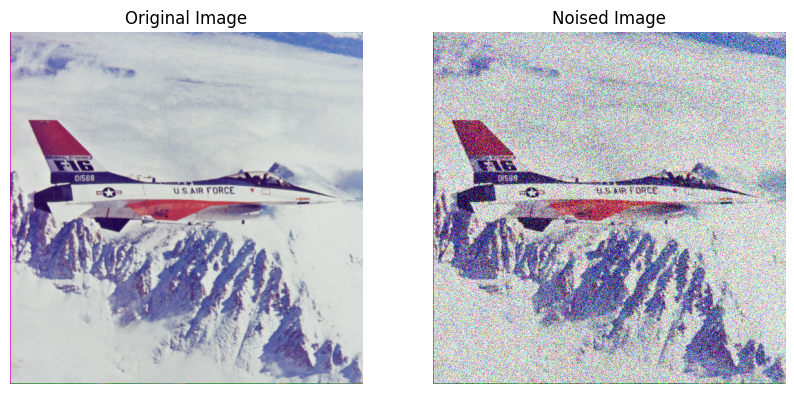

In [85]:
# Example usage
fname = 'data/denoising/F16_GT.png'
origin_img = plt.imread(fname)  # Load image using matplotlib
#add some noise
origin_noised_img = origin_img + np.random.normal(0, 0.2, origin_img.shape)
origin_noised_img = np.clip(origin_noised_img, 0, 1)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(origin_img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(origin_noised_img)
ax[1].set_title('Noised Image')
ax[1].axis('off')

In [86]:
from ipywidgets import IntSlider, interactive, HBox
import ipywidgets as widgets
from IPython.display import display
iterations = 1000
beta_start = 1e-4  # Initial noise scale factor
beta_end = 0.02    # Final noise scale factor

noise_img = ddpm_forward(origin_noised_img, iterations, beta_start, beta_end, noise_scheduler="cosine")

slider = IntSlider(min=0, max=len(noise_img)-4, value=0)

# 定義一個函數來顯示選定的圖像
def display_images(idx):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        axes[i].imshow(noise_img[idx+i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# 創建一個交互式小工具
interactive_widget = interactive(display_images, idx=slider)
display(interactive_widget)

interactive(children=(IntSlider(value=0, description='idx', max=96), Output()), _dom_classes=('widget-interact…

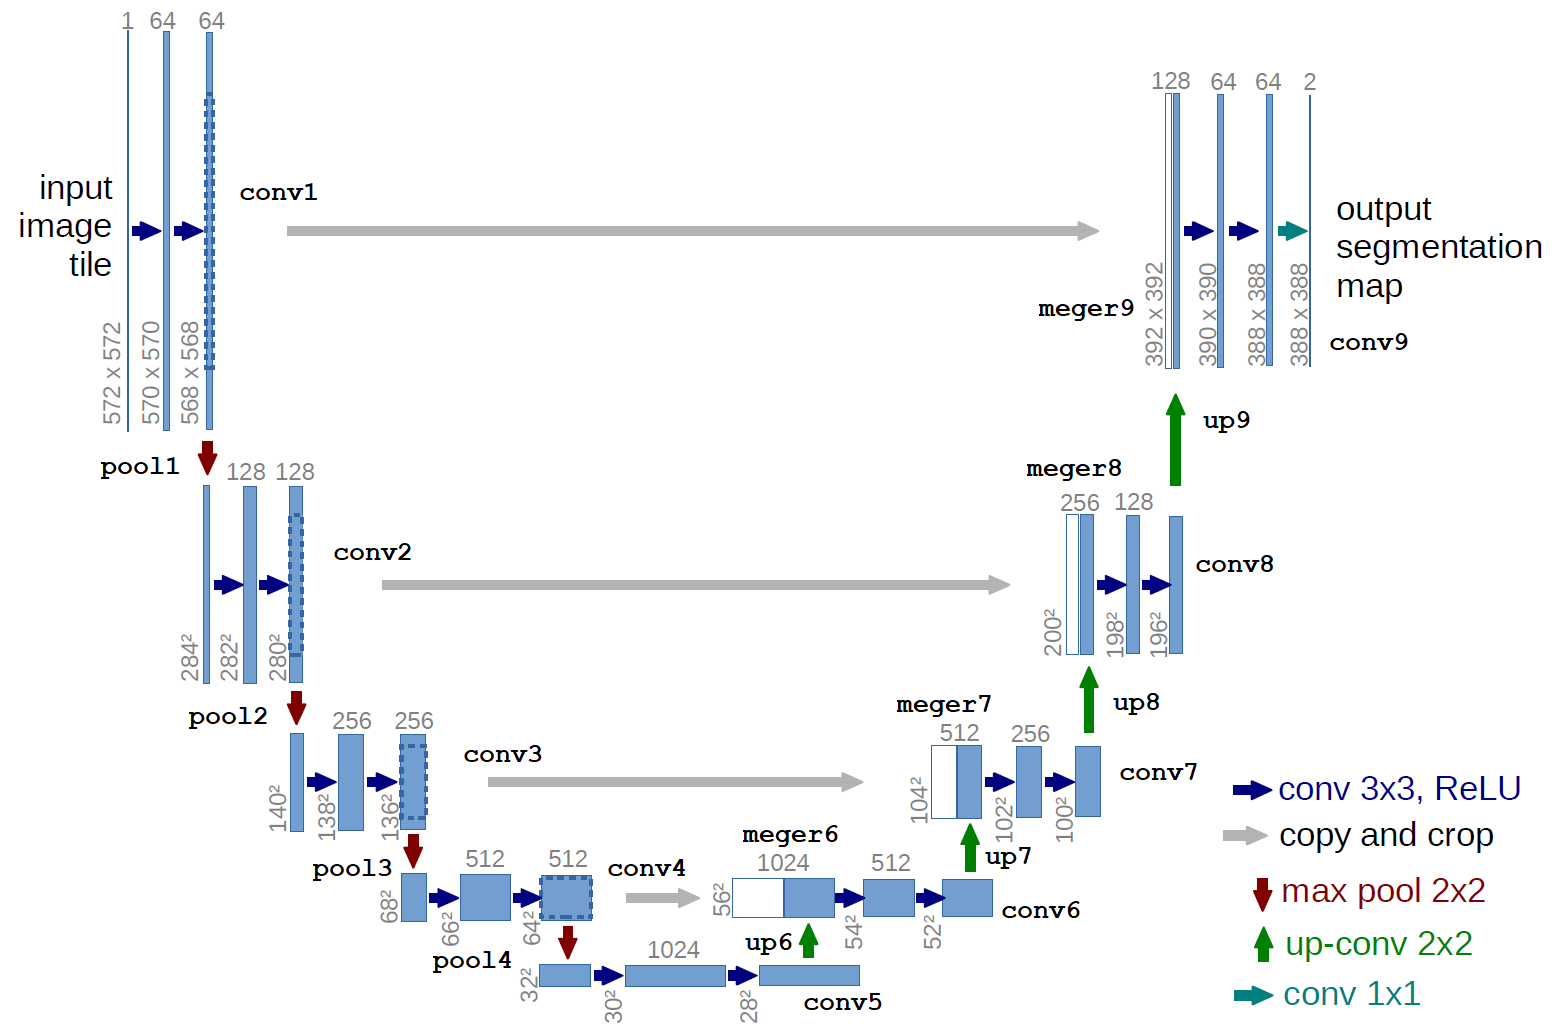

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Define the double conv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define the UNet model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, feature_maps):
        super(UNet, self).__init__()
        
      
        #downsampling
        self.conv1 = DoubleConv(in_channels, feature_maps[0])
        # pool1
        self.conv2 = DoubleConv(feature_maps[0], feature_maps[1])
        # pool2
        self.conv3 = DoubleConv(feature_maps[1], feature_maps[2])
        # pool3
        self.conv4 = DoubleConv(feature_maps[2], feature_maps[3])
        # pool4
        #maxpool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #pool 1, 2, 3, 4
        
        #bridge
        self.conv5 = DoubleConv(feature_maps[3], feature_maps[4])
        
        #upsampling
        self.conv6 = DoubleConv(feature_maps[4], feature_maps[3])
        self.up6 = nn.ConvTranspose2d(feature_maps[4], feature_maps[3], kernel_size=2, stride=2)
        self.conv7 = DoubleConv(feature_maps[3], feature_maps[2])
        self.up7 = nn.ConvTranspose2d(feature_maps[3], feature_maps[2], kernel_size=2, stride=2)
        self.conv8 = DoubleConv(feature_maps[2], feature_maps[1])
        self.up8 = nn.ConvTranspose2d(feature_maps[2], feature_maps[1], kernel_size=2, stride=2)
        self.conv9 = DoubleConv(feature_maps[1], feature_maps[0])
        self.up9 = nn.ConvTranspose2d(feature_maps[1], feature_maps[0], kernel_size=2, stride=2)
        self.conv10 = nn.Conv2d(feature_maps[0], out_channels, kernel_size=1)

    def forward(self, x):
        
        c1 = self.conv1(x)
        p1 = self.max_pool(c1)
        c2 = self.conv2(p1)
        p2 = self.max_pool(c2)
        c3 = self.conv3(p2)
        p3 = self.max_pool(c3)
        c4 = self.conv4(p3)
        p4 = self.max_pool(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        # out = nn.Sigmoid()(c10)
        out = c10
        
        return out

In [88]:
#reverse noise_img
rev_noise_img = noise_img[::-1]
n_stage = len(noise_img)
# Display the images
# fig, axes = plt.subplots(1, len(rev_noise_img), figsize=(20, 5))

# for i, img in enumerate(rev_noise_img):
#     axes[i].imshow(img)
#     axes[i].axis('off')

# print(n_stage)
# plt.tight_layout()
# plt.show()

In [89]:
import numpy as np

def allocate_iterations(betas, iterations, chunk_size=10, max_iterations=10):
    summed_betas = []
    chunk_iterations = []
    for i in range(0, iterations, chunk_size):
        end_idx = min(i + chunk_size, iterations)
        summed_betas.append(np.sum(betas[i:end_idx]))
        chunk_iterations.append(end_idx - i)
    total_sum = np.sum(summed_betas)
    allocated_iterations = [min(int(it * iterations / total_sum), max_iterations) for it in summed_betas]
    # 处理迭代数的舍入误差
    remaining_iterations = iterations - sum(allocated_iterations)
    for i, it in enumerate(allocated_iterations):
        if remaining_iterations > 0 and allocated_iterations[i] != max_iterations:
            allocated_iterations[i] += 1
            remaining_iterations -= 1
    return allocated_iterations, chunk_iterations

# 示例使用
iterations = 1000
beta_start = 1e-4
beta_end = 0.02
betas = np.linspace(beta_start**2, beta_end**2.5, iterations)
allocated_iterations, chunk_iterations = allocate_iterations(betas, iterations)
print("Allocated iterations:", allocated_iterations)
print("Chunk iterations:", chunk_iterations)

Allocated iterations: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Chunk iterations: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [90]:
print(len(allocated_iterations))

100


In [95]:
import skimage
# Example usage
in_channels = 3
out_channels = 3
feature_maps = [16, 32, 64, 128, 256]
# feature_maps = [32, 64, 128, 256, 512]

model = UNet(in_channels, out_channels, feature_maps)
model = model.to("cuda")

# target_tensor = torch.from_numpy(input_img.transpose(2, 0, 1) / 255.0).float().unsqueeze(0)
target_tensor = torch.from_numpy(origin_noised_img.transpose(2, 0, 1)).float().unsqueeze(0)

target_tensor_list = [torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0) for img in rev_noise_img]

input_tensor = target_tensor.clone()  # Use input as target for deep image prior
# random from gaussian distribution
input_tensor = torch.randn_like(input_tensor)  # Random input image
dataset = TensorDataset(input_tensor, target_tensor)  # Use input as target for deep image prior
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

img_list = []
pre_psnr=0
cur_tensor_idx = 0
cur_iterations = 0

for epoch in range(num_epochs):
    for input_batch, _ in data_loader:
        target_batch = target_tensor_list[cur_tensor_idx]
        input_batch = input_batch.to("cuda")
        target_batch = target_batch.to("cuda")
        optimizer.zero_grad()
        output = model(input_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()

        cur_iterations += 1
        if cur_iterations == allocated_iterations[cur_tensor_idx]:
            cur_tensor_idx += 1
            cur_iterations = 0
            print(f'Stage: {cur_tensor_idx}')
            # if cur_tensor_idx < len(target_batch_list):
            #     target_tensor = target_batch_list[cur_tensor_idx]
            #     dataset = TensorDataset(input_tensor, target_tensor)
            #     data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

        # if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
            #using Peak Signal-to-Noise Ratio (PSNR) to evaluate the model
            psnr = skimage.metrics.peak_signal_noise_ratio(target_batch.squeeze().permute(1, 2, 0).cpu().numpy(), 
                                                           output.detach().squeeze().permute(1, 2, 0).cpu().numpy())
            print(f'PSNR: {psnr:.2f} dB')
            noise_img = output.detach().squeeze().permute(1, 2, 0).cpu().numpy()
            noise_img = np.clip(noise_img, 0, 1)
            img_list.append(noise_img)
    if(cur_tensor_idx == 100):
        break

Stage: 1
Epoch [1/1000], Loss: 0.8408
PSNR: 0.75 dB
Stage: 2
Epoch [2/1000], Loss: 0.8055
PSNR: 0.94 dB
Stage: 3
Epoch [3/1000], Loss: 0.7778
PSNR: 1.09 dB
Stage: 4
Epoch [4/1000], Loss: 0.7541
PSNR: 1.23 dB
Stage: 5
Epoch [5/1000], Loss: 0.7321
PSNR: 1.35 dB
Stage: 6
Epoch [7/1000], Loss: 0.6888
PSNR: 1.62 dB
Stage: 7
Epoch [9/1000], Loss: 0.6380
PSNR: 1.95 dB
Stage: 8
Epoch [11/1000], Loss: 0.5710
PSNR: 2.43 dB
Stage: 9
Epoch [13/1000], Loss: 0.5050
PSNR: 2.97 dB
Stage: 10
Epoch [15/1000], Loss: 0.4396
PSNR: 3.57 dB
Stage: 11
Epoch [18/1000], Loss: 0.3639
PSNR: 4.39 dB
Stage: 12
Epoch [21/1000], Loss: 0.3262
PSNR: 4.86 dB
Stage: 13
Epoch [24/1000], Loss: 0.3015
PSNR: 5.21 dB
Stage: 14
Epoch [27/1000], Loss: 0.2805
PSNR: 5.52 dB
Stage: 15
Epoch [30/1000], Loss: 0.2669
PSNR: 5.74 dB
Stage: 16
Epoch [34/1000], Loss: 0.2502
PSNR: 6.02 dB
Stage: 17
Epoch [38/1000], Loss: 0.2366
PSNR: 6.26 dB
Stage: 18
Epoch [42/1000], Loss: 0.2247
PSNR: 6.48 dB
Stage: 19
Epoch [46/1000], Loss: 0.2143
PSNR

In [96]:
def display_denoise_images(idx):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        axes[i].imshow(img_list[idx+i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# 創建一個交互式小工具
interactive_widget = interactive(display_denoise_images, idx=slider)
display(interactive_widget)

interactive(children=(IntSlider(value=75, description='idx', max=96), Output()), _dom_classes=('widget-interac…

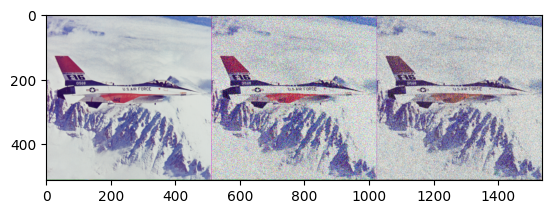

In [98]:
# Generate a random image
random_image = np.random.randint(0, 256, size=(512, 512, 3), dtype=np.uint8)

test_tensor = torch.from_numpy(random_image.transpose(2, 0, 1)).float().unsqueeze(0)
model = model.to("cpu")
# Evaluate the model
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    
    
output_img = output.squeeze().permute(1, 2, 0).numpy()
output_img = np.clip(output_img, 0, 1)
compare_img = np.concatenate([origin_img, origin_noised_img, output_img], axis=1)
plt.imshow(compare_img)

In [103]:
import skimage
psnr_1 = skimage.metrics.peak_signal_noise_ratio(origin_img, origin_noised_img)
psnr_2 = skimage.metrics.peak_signal_noise_ratio(origin_img, output_img)
print(psnr_1, psnr_2)

14.97500371079731 19.98915345202341


/tmp/ipykernel_35/1713595551.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_1 = skimage.metrics.peak_signal_noise_ratio(origin_img, origin_noised_img)
